[Forecasting: Principles and Practice](https://otexts.com/fpp2/)

In [1]:
import pandas as pd

from graph_traffic.get_data import get_data
from graph_traffic.config import figures_path, project_path
from graph_traffic.dataloading import npzDataset
from graph_traffic.baseline_models import MeanRegressor, MedianRegressor, RepeatRegressor, RepeatLastRegressor, DaytimeRegressor, DriftRegressor
from graph_traffic.model_selection import timeseries_cv, plot_predictions, print_losses, get_node_ids
from graph_traffic.merge_data import merge_data
from random import choices
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np
import pickle

baseline_path = figures_path + "/baseline"

ids_to_use = get_node_ids()
print(f"total of {len(ids_to_use)} nodes")
data_dict = dict(
    ids_list=ids_to_use[:1],#[3954, 3973, 3976, 3977, 3978],#[3532, 3542, 3544, 3545, 3546, 3577, 3637, 3640, 3641, 4761, 4763],
    seq_len=8,
    with_graph=False,
    from_date="2019-01-01",
    to_date="2021-12-31",
    dataset_name="small",
    target="ocupacion",
    interactions="drop"
)

meteo_dict = dict(
    rain="drop",
    wind="drop",
    temperature="drop",
    humidity="drop",
    pressure="drop",
    radiation="drop"
)

temporal_dict = dict(
    year="drop",
    season="drop",
    month="drop",
    day_of_month="drop",
    weekday="drop",
    hour="passthrough",
    minute="drop",
    bank_holiday="drop",
    school_holiday="drop",
    working_day="passthrough",
    state_of_alarm="drop"
)

get_data(data_dict, meteo_dict, temporal_dict)#, train_until="2021-05-31")
dataset_name = data_dict["dataset_name"]
n_points = None

C:\Users\Bened\PycharmProjects\madrid-traffic\env\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


total of 37 nodes


In [2]:
train_data = npzDataset(dataset_name, "train", n_points)
test_data = npzDataset(dataset_name, "test", n_points)

train_x = train_data.x
train_y = train_data.y

test_x = test_data.x
test_y = test_data.y

In [3]:
random_samples = choices(range(test_x.shape[0]), k=2)
random_samples

[17039, 14988]

In [4]:
train_x.shape, test_x.shape

((79565, 8, 1, 3), (19892, 8, 1, 3))

# 1. Mean regressor

In [5]:
estimators, train_losses, test_losses = timeseries_cv(MeanRegressor(), train_x, train_y)
print_losses(train_losses, test_losses)

Train MAE: 16.56, std: 0.37
Train MSE: 370.38, std: 15.75
Test MAE: 16.99, std: 0.79
Test MSE: 387.05, std: 35.46


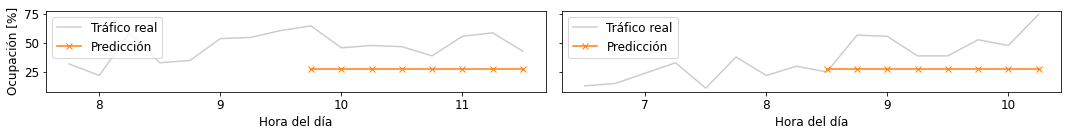

In [7]:
plot_predictions(estimators[-1], test_x, test_y, random_samples, data_dict["ids_list"], data_dict["seq_len"], name_save=baseline_path + "/mean.png")

# 2. Median regressor

In [8]:
estimators, train_losses, test_losses = timeseries_cv(MedianRegressor(), train_x, train_y)
print_losses(train_losses, test_losses)

Train MAE: 16.55, std: 0.37
Train MSE: 371.19, std: 15.80
Test MAE: 16.94, std: 0.85
Test MSE: 386.32, std: 37.84


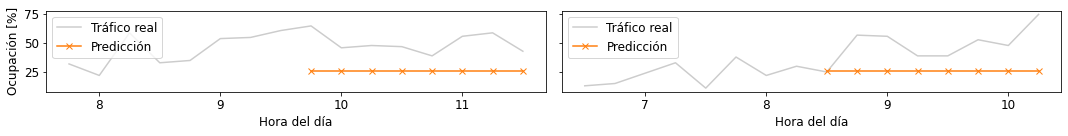

In [9]:
plot_predictions(estimators[-1], test_x, test_y, random_samples, data_dict["ids_list"], data_dict["seq_len"], name_save=baseline_path + "/median.png")

# 3. Repeat regressor

In [10]:
estimators, train_losses, test_losses = timeseries_cv(RepeatRegressor(), train_x, train_y)
print_losses(train_losses, test_losses)

Train MAE: 13.17, std: 0.22
Train MSE: 289.24, std: 9.62
Test MAE: 13.03, std: 0.78
Test MSE: 285.13, std: 33.10


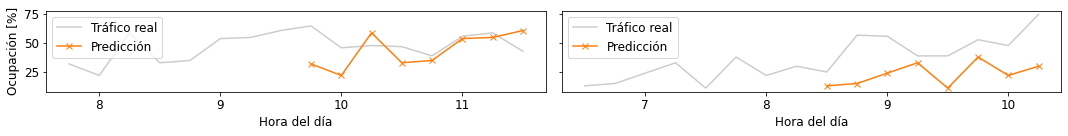

In [11]:
plot_predictions(estimators[-1], test_x, test_y, random_samples, data_dict["ids_list"], data_dict["seq_len"], name_save=baseline_path + "/repeat.png")

# 4. Repeat last value regressor

In [12]:
estimators, train_losses, test_losses = timeseries_cv(RepeatLastRegressor(), train_x, train_y)
print_losses(train_losses, test_losses)

Train MAE: 11.11, std: 0.13
Train MSE: 213.51, std: 5.36
Test MAE: 11.04, std: 0.50
Test MSE: 212.59, std: 18.99


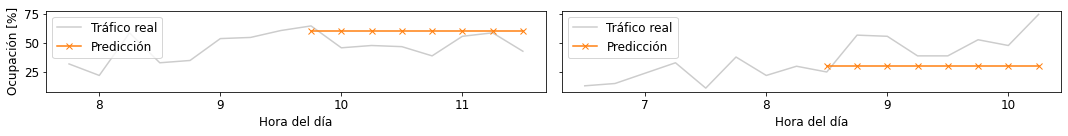

In [13]:
plot_predictions(estimators[-1], test_x, test_y, random_samples, data_dict["ids_list"], data_dict["seq_len"], name_save=baseline_path + "/repeat_last.png")

# 5. Mean per hour

In [14]:
estimators, train_losses, test_losses = timeseries_cv(DaytimeRegressor("mean"), train_x[:, :, :, [0, 1]], train_y)
print_losses(train_losses, test_losses)

Train MAE: 8.84, std: 0.49
Train MSE: 140.78, std: 17.08
Test MAE: 9.80, std: 1.14
Test MSE: 177.28, std: 44.43


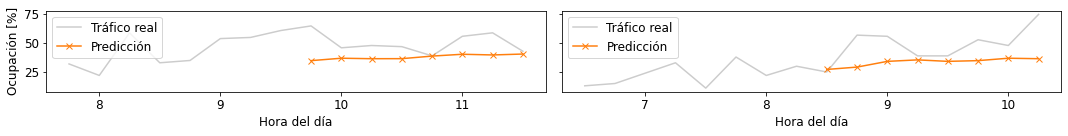

In [15]:
plot_predictions(estimators[-1], test_x, test_y, random_samples, data_dict["ids_list"], data_dict["seq_len"], name_save=baseline_path + "/mean_hour.png")

In [16]:
estimators, train_losses, test_losses = timeseries_cv(DaytimeRegressor("mean", by_working_day=True), train_x[:, :, :, [0, 1, 2]], train_y)
print_losses(train_losses, test_losses)

Train MAE: 7.77, std: 0.56
Train MSE: 112.31, std: 19.30
Test MAE: 8.92, std: 1.37
Test MSE: 155.13, std: 50.33


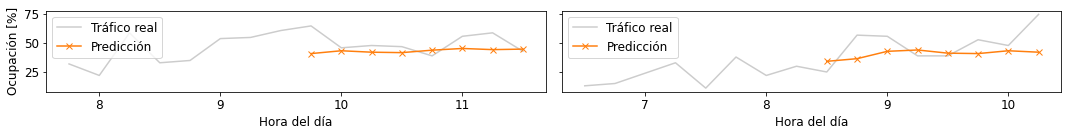

In [17]:
plot_predictions(estimators[-1], test_x, test_y, random_samples, data_dict["ids_list"], data_dict["seq_len"], name_save=baseline_path + "/mean_hour_workingday.png")

# 6. Median per hour

In [18]:
estimators, train_losses, test_losses = timeseries_cv(DaytimeRegressor("median"), train_x[:, :, :, [0, 1]], train_y)
print_losses(train_losses, test_losses)

Train MAE: 8.77, std: 0.49
Train MSE: 142.65, std: 17.17
Test MAE: 9.72, std: 1.25
Test MSE: 179.17, std: 47.91


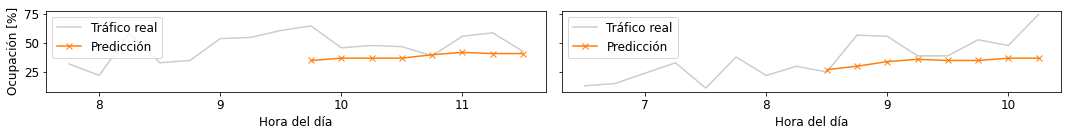

In [19]:
plot_predictions(estimators[-1], test_x, test_y, random_samples, data_dict["ids_list"], data_dict["seq_len"], name_save=baseline_path + "/median_hour.png")

In [20]:
estimators, train_losses, test_losses = timeseries_cv(DaytimeRegressor("median", by_working_day=True), train_x[:, :, :, [0, 1, 2]], train_y)
print_losses(train_losses, test_losses)

Train MAE: 7.67, std: 0.56
Train MSE: 114.10, std: 19.51
Test MAE: 8.80, std: 1.39
Test MSE: 155.23, std: 49.97


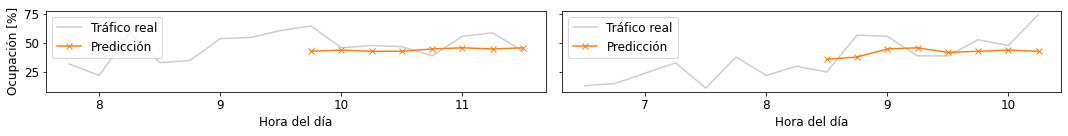

In [21]:
plot_predictions(estimators[-1], test_x, test_y, random_samples, data_dict["ids_list"], data_dict["seq_len"], name_save=baseline_path + "/median_hour_workingday.png")

# 7. Drift regressor

In [22]:
estimators, train_losses, test_losses = timeseries_cv(DriftRegressor(), train_x, train_y)
print_losses(train_losses, test_losses)

Train MAE: 13.47, std: 0.12
Train MSE: 332.85, std: 6.44
Test MAE: 13.36, std: 0.46
Test MSE: 329.63, std: 23.57


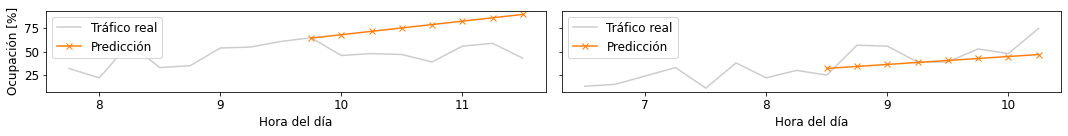

In [23]:
plot_predictions(estimators[-1], test_x, test_y, random_samples, data_dict["ids_list"], data_dict["seq_len"], name_save=baseline_path + "/drift.png")